In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
graph_builder = StateGraph(State)

In [3]:
# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")
# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
graph = graph_builder.compile()

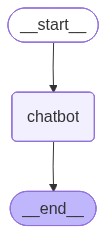

In [5]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# グラフの実行
response = graph.invoke({"messages": [("user", "光の三原色は？")]})

# 結果の表示
print(response)

{'messages': [HumanMessage(content='光の三原色は？', additional_kwargs={}, response_metadata={}, id='7a55e141-b0c4-411f-aa06-71596049bd00'), AIMessage(content='光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの色を組み合わせることで、さまざまな色を作り出すことができます。この原理は、ディスプレイや照明など、光を使用する技術において広く応用されています。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 14, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'finish_reason': 'stop', 'logprobs': None}, id='run-858737be-d86e-49f6-9c5b-6d9651d805bf-0', usage_metadata={'input_tokens': 14, 'output_tokens': 76, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [7]:
# 言語モデルからの回答のみを表示
print(response["messages"][-1].content)

光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの色を組み合わせることで、さまざまな色を作り出すことができます。この原理は、ディスプレイや照明など、光を使用する技術において広く応用されています。


In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            print("回答:", value["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)

質問: 光の三原色は？
回答: 光の三原色は、赤（Red）、緑（Green）、青（Blue）の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。この原理は、RGBカラーシステムに基づいており、コンピュータのディスプレイやテレビなどのデジタル表示に広く用いられています。
ありがとうございました!


In [9]:
from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
memory_graph = graph_builder.compile(checkpointer=memory)

In [10]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)


aで始まる英単語を5つ教えて
もちろんです！以下は「a」で始まる英単語を5つ挙げます：

1. Apple（リンゴ）
2. Airplane（飛行機）
3. Art（芸術）
4. Amazing（驚くべき）
5. Adventure（冒険）

何か他に知りたいことがあれば教えてください！
4つ目の英単語は何ですか？
4つ目の英単語は「Amazing」です。意味は「驚くべき」や「素晴らしい」ということです。他に知りたいことがあれば教えてください！
ありがとうございました!
